## Importing libraries

In [1]:
import networkx as nx
import pandas as pd
import networkx.algorithms.community as nx_comm
import community as community_louvain
import matplotlib.cm as cm
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import powerlaw

#### the list of all airlines (open source dataset)

In [2]:
airports_ext = pd.read_csv('https://raw.githubusercontent.com/VladislavsLuksha/European_Air_Transportation_Network/main/DATA/Flights%20Data/OpenFlights/airports.csv')
airports_ext = airports_ext.iloc[:,:9]
airports_ext.head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146


#### the list of all airports (open source dataset)

In [3]:
from FlightRadar24.api import FlightRadar24API
fr_api = FlightRadar24API()


In [4]:
airports = fr_api.get_airports()

In [5]:
airports = pd.DataFrame(airports)
airports.head()

,name,iata,icao,lat,lon,country,alt
0,A Coruna Airport,LCG,LECO,43.302059,-8.377250,Spain,326
1,Aachen Merzbruck Airport,AAH,EDKA,50.823051,6.186111,Germany,623
2,Aalborg Airport,AAL,EKYT,57.092781,9.849164,Denmark,10
3,Aarhus Airport,AAR,EKAH,56.300011,10.619000,Denmark,82
4,Aarhus Sea Airport,QEA,EKAC,56.151993,10.247725,Denmark,1


In [6]:
airports = airports.dropna()

In [7]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5042 entries, 0 to 5041
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     5042 non-null   object 
 1   iata     5042 non-null   object 
 2   icao     5042 non-null   object 
 3   lat      5042 non-null   float64
 4   lon      5042 non-null   float64
 5   country  5042 non-null   object 
 6   alt      5042 non-null   object 
dtypes: float64(2), object(5)
memory usage: 275.9+ KB


#### Europe airports

In [200]:
lat_min = 34.3
lat_max = 71.3
long_min = -25.3
long_max = 50.0


# Filter the DataFrame to only include locations within the boundaries
airports_eur = airports[(airports['lat'] >= lat_min) & (airports['lat'] <= lat_max) &
        (airports['lon'] >= long_min) & (airports['lon'] <= long_max)]

In [201]:
# List of countries to remove
countries_to_remove = ['Libya', 'Syria','Algeria','Tunisia','Morocco','Egypt','Iran','Iraq']

# Create a Boolean mask that identifies the rows to be removed
mask = airports_eur['country'].isin(countries_to_remove)

# Drop the rows identified by the Boolean mask
airports_eur = airports_eur[~mask]


In [202]:
import folium

# Define the center point for the map
center_lat = (lat_min + lat_max) / 2
center_long = (long_min + long_max) / 2

# Create a map centered on the defined center point
m = folium.Map(location=[center_lat, center_long], zoom_start=3)

# Add a rectangle to the map to represent the boundaries
folium.Rectangle(
    bounds = [[lat_min, long_min], [lat_max, long_max]],
    color='blue',
    fill= False
).add_to(m)

# Add markers for each airport in the DataFrame
for index, row in airports_eur.iterrows():
   if lat_min <= row['lat'] <= lat_max and long_min <= row['lon'] <= long_max:
        radius = 2  # Change the radius to adjust the size of the dots
        color = 'blue'  # Change the color of the dots
        fill_color = 'blue'  # Change the fill color of the dots
        fill_opacity = 0.2  # Change the fill opacity of the dots
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=radius,
            color=color,
            fill_color=fill_color,
            fill_opacity=fill_opacity,
            tooltip=row['name']
        ).add_to(m)

# Show the map
m

In [203]:
airports_eur.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986 entries, 0 to 5040
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     986 non-null    object 
 1   iata     986 non-null    object 
 2   icao     986 non-null    object 
 3   lat      986 non-null    float64
 4   lon      986 non-null    float64
 5   country  986 non-null    object 
 6   alt      986 non-null    object 
dtypes: float64(2), object(5)
memory usage: 61.6+ KB


# THE CODE FOR OBTAINING SCHEDULES

In [204]:
#getting data for european airports (before war)

In [205]:
import pandas as pd
from tqdm import tqdm
import requests
import json

# Replace [API_KEY] with your own API key
API_KEY = '_______'

# Define the start and end dates
start_date = '2022-08-07'
end_date = '2022-08-14'

airport_codes= list(airports_eur['iata'].unique())

# Initialize an empty list to store the API responses
responses = []

# Loop over the list of airport codes
for airport in tqdm(airport_codes, desc='Getting timetable'):
    # Make a GET request to the API
    url = f'https://aviation-edge.com/v2/public/flightsHistory?key={API_KEY}&code={airport}&type=departure&date_from={start_date}&date_to={end_date}'
    response = requests.get(url,timeout=10)
    
    # Add the API response to the list
    try:
        responses.append(response.json())
    except json.JSONDecodeError as e:
        print(f'Error decoding JSON response for {airport}: {e}')

Getting timetable:  13%|██▉                   | 132/986 [01:54<05:08,  2.77it/s]

Error decoding JSON response for BES: Expecting value: line 1 column 1 (char 0)


Getting timetable: 100%|██████████████████████| 986/986 [11:50<00:00,  1.39it/s]


In [206]:
df_list = []
for sublist in responses:
    try:
        df_list.append(pd.DataFrame(sublist))
    except ValueError as e:
        print("Error while converting JSON to dataframe:", e)

df = pd.concat(df_list)

Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, 

In [207]:
#df= df.drop(columns ='codeshared')
df = df.reset_index(drop=True)
df.head()

,type,status,departure,arrival,airline,flight,codeshared
0,departure,active,"{'iataCode': 'lcg', 'icaoCode': 'leco', 'termi...","{'iataCode': 'bcn', 'icaoCode': 'lebl', 'termi...","{'name': 'iberia', 'iataCode': 'ib', 'icaoCode...","{'number': '5031', 'iataNumber': 'ib5031', 'ic...","{'airline': {'name': 'vueling', 'iataCode': 'v..."
1,departure,active,"{'iataCode': 'lcg', 'icaoCode': 'leco', 'termi...","{'iataCode': 'bcn', 'icaoCode': 'lebl', 'termi...","{'name': 'latam airlines', 'iataCode': 'la', '...","{'number': '5813', 'iataNumber': 'la5813', 'ic...","{'airline': {'name': 'vueling', 'iataCode': 'v..."
2,departure,active,"{'iataCode': 'lcg', 'icaoCode': 'leco', 'termi...","{'iataCode': 'bcn', 'icaoCode': 'lebl', 'termi...","{'name': 'qatar airways', 'iataCode': 'qr', 'i...","{'number': '3523', 'iataNumber': 'qr3523', 'ic...","{'airline': {'name': 'vueling', 'iataCode': 'v..."
3,departure,active,"{'iataCode': 'lcg', 'icaoCode': 'leco', 'termi...","{'iataCode': 'bcn', 'icaoCode': 'lebl', 'termi...","{'name': 'vueling', 'iataCode': 'vy', 'icaoCod...","{'number': '1293', 'iataNumber': 'vy1293', 'ic...",NaN
4,departure,active,"{'iataCode': 'lcg', 'icaoCode': 'leco', 'termi...","{'iataCode': 'mad', 'icaoCode': 'lemd', 'termi...","{'name': 'sa avianca', 'iataCode': 'av', 'icao...","{'number': '6012', 'iataNumber': 'av6012', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib..."


In [208]:
df = df.drop(columns = ['type'])

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293005 entries, 0 to 293004
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   status      293005 non-null  object
 1   departure   293005 non-null  object
 2   arrival     293005 non-null  object
 3   airline     293005 non-null  object
 4   flight      293005 non-null  object
 5   codeshared  115946 non-null  object
dtypes: object(6)
memory usage: 13.4+ MB


In [210]:
# Use pandas.json_normalize() to extract the values from the dictionaries
departures = pd.json_normalize(df['departure'])

# Rename the columns to include 'departure' and the dictionary key
departures.columns = ['departure_' + col for col in departures.columns]

# Concatenate the original DataFrame and the new departures DataFrame
ndf = pd.concat([df, departures], axis=1)

# Drop the original 'departure' column
ndf = ndf.drop('departure', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,arrival,airline,flight,codeshared,departure_iataCode,departure_icaoCode,departure_terminal,departure_gate,departure_delay,departure_scheduledTime,departure_estimatedTime,departure_actualTime,departure_estimatedRunway,departure_actualRunway
0,active,"{'iataCode': 'bcn', 'icaoCode': 'lebl', 'termi...","{'name': 'iberia', 'iataCode': 'ib', 'icaoCode...","{'number': '5031', 'iataNumber': 'ib5031', 'ic...","{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,leco,t1,4,9.0,2022-08-07t09:15:00.000,2022-08-07t09:24:00.000,NaN,NaN,NaN
1,active,"{'iataCode': 'bcn', 'icaoCode': 'lebl', 'termi...","{'name': 'latam airlines', 'iataCode': 'la', '...","{'number': '5813', 'iataNumber': 'la5813', 'ic...","{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,leco,t1,4,9.0,2022-08-07t09:15:00.000,2022-08-07t09:24:00.000,NaN,NaN,NaN
2,active,"{'iataCode': 'bcn', 'icaoCode': 'lebl', 'termi...","{'name': 'qatar airways', 'iataCode': 'qr', 'i...","{'number': '3523', 'iataNumber': 'qr3523', 'ic...","{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,leco,t1,4,9.0,2022-08-07t09:15:00.000,2022-08-07t09:24:00.000,NaN,NaN,NaN
3,active,"{'iataCode': 'bcn', 'icaoCode': 'lebl', 'termi...","{'name': 'vueling', 'iataCode': 'vy', 'icaoCod...","{'number': '1293', 'iataNumber': 'vy1293', 'ic...",NaN,lcg,leco,t1,4,9.0,2022-08-07t09:15:00.000,2022-08-07t09:24:00.000,NaN,NaN,NaN
4,active,"{'iataCode': 'mad', 'icaoCode': 'lemd', 'termi...","{'name': 'sa avianca', 'iataCode': 'av', 'icao...","{'number': '6012', 'iataNumber': 'av6012', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,leco,t1,3,NaN,2022-08-07t09:20:00.000,2022-08-07t09:20:00.000,NaN,NaN,NaN


In [211]:
ndf = ndf.drop(columns = ['departure_icaoCode','departure_actualTime', 'departure_estimatedRunway' , 'departure_actualRunway', 'departure_terminal' , 'departure_gate', 'departure_estimatedTime'])
ndf.head()

,status,arrival,airline,flight,codeshared,departure_iataCode,departure_delay,departure_scheduledTime
0,active,"{'iataCode': 'bcn', 'icaoCode': 'lebl', 'termi...","{'name': 'iberia', 'iataCode': 'ib', 'icaoCode...","{'number': '5031', 'iataNumber': 'ib5031', 'ic...","{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,9.0,2022-08-07t09:15:00.000
1,active,"{'iataCode': 'bcn', 'icaoCode': 'lebl', 'termi...","{'name': 'latam airlines', 'iataCode': 'la', '...","{'number': '5813', 'iataNumber': 'la5813', 'ic...","{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,9.0,2022-08-07t09:15:00.000
2,active,"{'iataCode': 'bcn', 'icaoCode': 'lebl', 'termi...","{'name': 'qatar airways', 'iataCode': 'qr', 'i...","{'number': '3523', 'iataNumber': 'qr3523', 'ic...","{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,9.0,2022-08-07t09:15:00.000
3,active,"{'iataCode': 'bcn', 'icaoCode': 'lebl', 'termi...","{'name': 'vueling', 'iataCode': 'vy', 'icaoCod...","{'number': '1293', 'iataNumber': 'vy1293', 'ic...",NaN,lcg,9.0,2022-08-07t09:15:00.000
4,active,"{'iataCode': 'mad', 'icaoCode': 'lemd', 'termi...","{'name': 'sa avianca', 'iataCode': 'av', 'icao...","{'number': '6012', 'iataNumber': 'av6012', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,NaN,2022-08-07t09:20:00.000


In [212]:
# Use pandas.json_normalize() to extract the values from the dictionaries
arrivals = pd.json_normalize(ndf['arrival'])

# Rename the columns to include 'arrival' and the dictionary key
arrivals.columns = ['arrival_' + col for col in arrivals.columns]

# Concatenate the original DataFrame and the new departures DataFrame
ndf = pd.concat([ndf, arrivals], axis=1)

# Drop the original 'departure' column
ndf = ndf.drop('arrival', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,airline,flight,codeshared,departure_iataCode,departure_delay,departure_scheduledTime,arrival_iataCode,arrival_icaoCode,arrival_terminal,arrival_baggage,arrival_scheduledTime,arrival_estimatedTime,arrival_delay,arrival_gate,arrival_actualTime,arrival_estimatedRunway,arrival_actualRunway
0,active,"{'name': 'iberia', 'iataCode': 'ib', 'icaoCode...","{'number': '5031', 'iataNumber': 'ib5031', 'ic...","{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,9.0,2022-08-07t09:15:00.000,bcn,lebl,1,06,2022-08-07t11:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN
1,active,"{'name': 'latam airlines', 'iataCode': 'la', '...","{'number': '5813', 'iataNumber': 'la5813', 'ic...","{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,9.0,2022-08-07t09:15:00.000,bcn,lebl,1,06,2022-08-07t11:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN
2,active,"{'name': 'qatar airways', 'iataCode': 'qr', 'i...","{'number': '3523', 'iataNumber': 'qr3523', 'ic...","{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,9.0,2022-08-07t09:15:00.000,bcn,lebl,1,06,2022-08-07t11:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN
3,active,"{'name': 'vueling', 'iataCode': 'vy', 'icaoCod...","{'number': '1293', 'iataNumber': 'vy1293', 'ic...",NaN,lcg,9.0,2022-08-07t09:15:00.000,bcn,lebl,1,06,2022-08-07t11:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN
4,active,"{'name': 'sa avianca', 'iataCode': 'av', 'icao...","{'number': '6012', 'iataNumber': 'av6012', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,NaN,2022-08-07t09:20:00.000,mad,lemd,4,16,2022-08-07t10:40:00.000,NaN,NaN,NaN,NaN,NaN,NaN


In [213]:
ndf = ndf.drop(columns = [ 'arrival_icaoCode' , 'arrival_terminal', 'arrival_baggage' ,'arrival_actualTime', 'arrival_estimatedTime', 'arrival_estimatedRunway','arrival_actualRunway','arrival_gate'])
ndf.head()

,status,airline,flight,codeshared,departure_iataCode,departure_delay,departure_scheduledTime,arrival_iataCode,arrival_scheduledTime,arrival_delay
0,active,"{'name': 'iberia', 'iataCode': 'ib', 'icaoCode...","{'number': '5031', 'iataNumber': 'ib5031', 'ic...","{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN
1,active,"{'name': 'latam airlines', 'iataCode': 'la', '...","{'number': '5813', 'iataNumber': 'la5813', 'ic...","{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN
2,active,"{'name': 'qatar airways', 'iataCode': 'qr', 'i...","{'number': '3523', 'iataNumber': 'qr3523', 'ic...","{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN
3,active,"{'name': 'vueling', 'iataCode': 'vy', 'icaoCod...","{'number': '1293', 'iataNumber': 'vy1293', 'ic...",NaN,lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN
4,active,"{'name': 'sa avianca', 'iataCode': 'av', 'icao...","{'number': '6012', 'iataNumber': 'av6012', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,NaN,2022-08-07t09:20:00.000,mad,2022-08-07t10:40:00.000,NaN


In [214]:
# Use pandas.json_normalize() to extract the values from the dictionaries
airlines = pd.json_normalize(ndf['airline'])

# Rename the columns to include 'airline' and the dictionary key
airlines.columns = ['airline_' + col for col in airlines.columns]

# Concatenate the original DataFrame and the new departures DataFrame
ndf = pd.concat([ndf, airlines], axis=1)

# Drop the original 'departure' column
ndf = ndf.drop('airline', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,flight,codeshared,departure_iataCode,departure_delay,departure_scheduledTime,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,airline_icaoCode
0,active,"{'number': '5031', 'iataNumber': 'ib5031', 'ic...","{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,iberia,ib,ibe
1,active,"{'number': '5813', 'iataNumber': 'la5813', 'ic...","{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,latam airlines,la,lan
2,active,"{'number': '3523', 'iataNumber': 'qr3523', 'ic...","{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,qatar airways,qr,qtr
3,active,"{'number': '1293', 'iataNumber': 'vy1293', 'ic...",NaN,lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,vueling,vy,vlg
4,active,"{'number': '6012', 'iataNumber': 'av6012', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,NaN,2022-08-07t09:20:00.000,mad,2022-08-07t10:40:00.000,NaN,sa avianca,av,ava


In [215]:
ndf = ndf.drop(columns = [ 'airline_icaoCode'])


In [216]:
# Use pandas.json_normalize() to extract the values from the dictionaries
flights = pd.json_normalize(ndf['flight'])

# Rename the columns to include 'flight' and the dictionary key
flights.columns = ['flight_' + col for col in flights.columns]

# Concatenate the original DataFrame and the new flights DataFrame
ndf = pd.concat([ndf, flights], axis=1)

# Drop the original 'flights' column
ndf = ndf.drop('flight', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,codeshared,departure_iataCode,departure_delay,departure_scheduledTime,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,flight_icaoNumber
0,active,"{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,iberia,ib,5031,ib5031,ibe5031
1,active,"{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,latam airlines,la,5813,la5813,lan5813
2,active,"{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,qatar airways,qr,3523,qr3523,qtr3523
3,active,NaN,lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,vueling,vy,1293,vy1293,vlg1293
4,active,"{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,NaN,2022-08-07t09:20:00.000,mad,2022-08-07t10:40:00.000,NaN,sa avianca,av,6012,av6012,ava6012


In [217]:
ndf = ndf.drop(columns = ['flight_icaoNumber'])
ndf.head()

,status,codeshared,departure_iataCode,departure_delay,departure_scheduledTime,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber
0,active,"{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,iberia,ib,5031,ib5031
1,active,"{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,latam airlines,la,5813,la5813
2,active,"{'airline': {'name': 'vueling', 'iataCode': 'v...",lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,qatar airways,qr,3523,qr3523
3,active,NaN,lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,vueling,vy,1293,vy1293
4,active,"{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,NaN,2022-08-07t09:20:00.000,mad,2022-08-07t10:40:00.000,NaN,sa avianca,av,6012,av6012


In [218]:
# Use pandas.json_normalize() to extract the values from the dictionaries
codeshared = pd.json_normalize(ndf['codeshared'])

# Rename the columns to include 'codeshared' and the dictionary key
codeshared.columns = ['codeshared_' + col for col in codeshared.columns]

# Concatenate the original DataFrame and the new codeshared DataFrame
ndf = pd.concat([ndf, codeshared], axis=1)

# Drop the original 'codeshared' column
ndf = ndf.drop('codeshared', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,departure_iataCode,departure_delay,departure_scheduledTime,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_airline.name,codeshared_airline.iataCode,codeshared_airline.icaoCode,codeshared_flight.number,codeshared_flight.iataNumber,codeshared_flight.icaoNumber
0,active,lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,iberia,ib,5031,ib5031,vueling,vy,vlg,1293,vy1293,vlg1293
1,active,lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,latam airlines,la,5813,la5813,vueling,vy,vlg,1293,vy1293,vlg1293
2,active,lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,qatar airways,qr,3523,qr3523,vueling,vy,vlg,1293,vy1293,vlg1293
3,active,lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,vueling,vy,1293,vy1293,NaN,NaN,NaN,NaN,NaN,NaN
4,active,lcg,NaN,2022-08-07t09:20:00.000,mad,2022-08-07t10:40:00.000,NaN,sa avianca,av,6012,av6012,iberia,ib,ibe,519,ib519,ibe519


In [219]:
ndf = ndf.drop(columns = [ 'codeshared_airline.iataCode','codeshared_airline.icaoCode','codeshared_flight.number','codeshared_flight.icaoNumber'])
ndf.head()

,status,departure_iataCode,departure_delay,departure_scheduledTime,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_airline.name,codeshared_flight.iataNumber
0,active,lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,iberia,ib,5031,ib5031,vueling,vy1293
1,active,lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,latam airlines,la,5813,la5813,vueling,vy1293
2,active,lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,qatar airways,qr,3523,qr3523,vueling,vy1293
3,active,lcg,9.0,2022-08-07t09:15:00.000,bcn,2022-08-07t11:00:00.000,NaN,vueling,vy,1293,vy1293,NaN,NaN
4,active,lcg,NaN,2022-08-07t09:20:00.000,mad,2022-08-07t10:40:00.000,NaN,sa avianca,av,6012,av6012,iberia,ib519


In [220]:
ndf.loc[ndf['codeshared_airline.name'].isnull(), 'codeshared_airline.name'] = ndf.loc[ndf['codeshared_airline.name'].isnull(), 'airline_name']
ndf.loc[ndf['codeshared_flight.iataNumber'].isnull(), 'codeshared_flight.iataNumber'] = ndf.loc[ndf['codeshared_flight.iataNumber'].isnull(), 'flight_iataNumber']
ndf['departure_delay'].fillna(0, inplace=True)


In [221]:
ndf.loc[ndf['arrival_delay'].isnull(), 'arrival_delay'] = ndf.loc[ndf['arrival_delay'].isnull(), 'departure_delay']
ndf[['departure_iataCode', 'arrival_iataCode']] = ndf[['departure_iataCode', 'arrival_iataCode']].applymap(str.upper)

In [222]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293005 entries, 0 to 293004
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   status                        293005 non-null  object 
 1   departure_iataCode            293005 non-null  object 
 2   departure_delay               293005 non-null  float64
 3   departure_scheduledTime       293005 non-null  object 
 4   arrival_iataCode              293005 non-null  object 
 5   arrival_scheduledTime         293005 non-null  object 
 6   arrival_delay                 293005 non-null  float64
 7   airline_name                  293005 non-null  object 
 8   airline_iataCode              293005 non-null  object 
 9   flight_number                 293005 non-null  object 
 10  flight_iataNumber             293005 non-null  object 
 11  codeshared_airline.name       293005 non-null  object 
 12  codeshared_flight.iataNumber  293005 non-nul

In [223]:
ndf.head()

,status,departure_iataCode,departure_delay,departure_scheduledTime,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_airline.name,codeshared_flight.iataNumber
0,active,LCG,9.0,2022-08-07t09:15:00.000,BCN,2022-08-07t11:00:00.000,9.0,iberia,ib,5031,ib5031,vueling,vy1293
1,active,LCG,9.0,2022-08-07t09:15:00.000,BCN,2022-08-07t11:00:00.000,9.0,latam airlines,la,5813,la5813,vueling,vy1293
2,active,LCG,9.0,2022-08-07t09:15:00.000,BCN,2022-08-07t11:00:00.000,9.0,qatar airways,qr,3523,qr3523,vueling,vy1293
3,active,LCG,9.0,2022-08-07t09:15:00.000,BCN,2022-08-07t11:00:00.000,9.0,vueling,vy,1293,vy1293,vueling,vy1293
4,active,LCG,0.0,2022-08-07t09:20:00.000,MAD,2022-08-07t10:40:00.000,0.0,sa avianca,av,6012,av6012,iberia,ib519


# ANALYSIS PART

In [ ]:
ndf = pd.read_csv('https://raw.githubusercontent.com/VladislavsLuksha/European_Air_Transportation_Network/main/DATA/Flights%20Data/codeshared/allflights22europe07081408.csv')

In [225]:
eur_g1 = ndf[ndf['flight_iataNumber'] == ndf['codeshared_flight.iataNumber']]

In [226]:
eur_g1 = eur_g1[eur_g1['status'] == 'active']

In [227]:
eur_g1 = eur_g1.drop_duplicates(subset=['departure_iataCode', 'departure_scheduledTime', 'arrival_iataCode'])

In [228]:
eur_g = eur_g1.drop(columns = ['status','departure_scheduledTime','departure_delay','flight_iataNumber','arrival_scheduledTime','arrival_delay','airline_iataCode','flight_number','codeshared_airline.name','codeshared_flight.iataNumber'])

In [229]:
eur_g = eur_g[eur_g['departure_iataCode'] != eur_g['arrival_iataCode']]


In [230]:
eur_g[(eur_g['departure_iataCode']=='LED' ) & (eur_g['arrival_iataCode']=='SVO')]

,departure_iataCode,arrival_iataCode,airline_name
251584,LED,SVO,aeroflot
251586,LED,SVO,aeroflot
251587,LED,SVO,aeroflot
251589,LED,SVO,aeroflot
251596,LED,SVO,aeroflot
...,...,...,...
253878,LED,SVO,aeroflot
253890,LED,SVO,aeroflot
253903,LED,SVO,aeroflot
253926,LED,SVO,aeroflot


In [233]:
###------------

In [318]:
df_grouped = eur_g.groupby(eur_g.columns.tolist()).size().reset_index(name='counts')

# Reset the index to remove the old index and create a new one
df_grouped = df_grouped.reset_index(drop=True)
df_grouped.sort_values('counts', ascending=False).head(20)

,departure_iataCode,arrival_iataCode,airline_name,counts
27511,SVO,LED,aeroflot,239
16242,LED,SVO,aeroflot,238
452,AER,SVO,aeroflot,177
27422,SVO,AER,aeroflot,172
2301,AYT,IST,turkish airlines,133
13837,IST,AYT,turkish airlines,131
16283,LED,VKO,rossiya airlines,111
2568,AYT,VKO,turkish airlines,111
8794,DME,AER,ural airlines,109
357,AER,DME,ural airlines,109


In [235]:
df_grouped['counts'] = round(df_grouped['counts'])


In [236]:
dflights_j =  df_grouped.merge(airports_ext, left_on='departure_iataCode', right_on='IATA')

In [237]:
dflights_j = dflights_j.drop(columns=['ICAO','IATA'])
dflights_j.head()

,departure_iataCode,arrival_iataCode,airline_name,counts,Airport ID,Name,City,Country,Latitude,Longitude,Altitude
0,AAL,AGP,norwegian air shuttle aoc,2,628,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,10
1,AAL,AMS,klm,26,628,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,10
2,AAL,ARN,ryanair,3,628,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,10
3,AAL,AYT,copenhagen airtaxi,1,628,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,10
4,AAL,AYT,corendon air,1,628,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,10


In [238]:
dflights_j = dflights_j.loc[:,['Airport ID','departure_iataCode','arrival_iataCode','Name','City','Country','Latitude','Longitude','airline_name','counts']]
dflights_j = dflights_j.rename(columns={"City": "City_origin", "Latitude":"Latitude_origin", "Longitude": "Longitude_origin", 'Country':'Country_origin','Name':'Name_origin','departure':'code_origin','arrival':'code_dest'})
dflights_j.head()

,Airport ID,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts
0,628,AAL,AGP,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,norwegian air shuttle aoc,2
1,628,AAL,AMS,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,klm,26
2,628,AAL,ARN,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,ryanair,3
3,628,AAL,AYT,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,copenhagen airtaxi,1
4,628,AAL,AYT,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,corendon air,1


In [239]:
dflights_j =  dflights_j.merge(airports_ext, left_on='arrival_iataCode', right_on='IATA')
dflights_j.head()

,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude
0,628,AAL,AGP,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,norwegian air shuttle aoc,2,1230,Málaga Airport,Malaga,Spain,AGP,LEMG,36.6749,-4.49911,53
1,607,AAR,AGP,Aarhus Airport,Aarhus,Denmark,56.299999,10.619000,ryanair,3,1230,Málaga Airport,Malaga,Spain,AGP,LEMG,36.6749,-4.49911,53
2,532,ABZ,AGP,Aberdeen Dyce Airport,Aberdeen,United Kingdom,57.201900,-2.197780,ryanair,2,1230,Málaga Airport,Malaga,Spain,AGP,LEMG,36.6749,-4.49911,53
3,1212,ALC,AGP,Alicante International Airport,Alicante,Spain,38.282200,-0.558156,tuifly,2,1230,Málaga Airport,Malaga,Spain,AGP,LEMG,36.6749,-4.49911,53
4,299,ANR,AGP,Antwerp International Airport (Deurne),Antwerp,Belgium,51.189400,4.460280,tuifly,8,1230,Málaga Airport,Malaga,Spain,AGP,LEMG,36.6749,-4.49911,53


In [240]:
dflights_j = dflights_j.drop(columns=['ICAO','IATA'])
dflights_j.head()

,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name,City,Country,Latitude,Longitude,Altitude
0,628,AAL,AGP,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,norwegian air shuttle aoc,2,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53
1,607,AAR,AGP,Aarhus Airport,Aarhus,Denmark,56.299999,10.619000,ryanair,3,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53
2,532,ABZ,AGP,Aberdeen Dyce Airport,Aberdeen,United Kingdom,57.201900,-2.197780,ryanair,2,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53
3,1212,ALC,AGP,Alicante International Airport,Alicante,Spain,38.282200,-0.558156,tuifly,2,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53
4,299,ANR,AGP,Antwerp International Airport (Deurne),Antwerp,Belgium,51.189400,4.460280,tuifly,8,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53


In [241]:
dflights_j = dflights_j.rename(columns={"City": "City_dest", "Latitude":"Latitude_dest", "Longitude": "Longitude_dest", 'Country':'Country_dest','Name':'Name_dest'})
dflights_j.head()


,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name_dest,City_dest,Country_dest,Latitude_dest,Longitude_dest,Altitude
0,628,AAL,AGP,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,norwegian air shuttle aoc,2,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53
1,607,AAR,AGP,Aarhus Airport,Aarhus,Denmark,56.299999,10.619000,ryanair,3,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53
2,532,ABZ,AGP,Aberdeen Dyce Airport,Aberdeen,United Kingdom,57.201900,-2.197780,ryanair,2,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53
3,1212,ALC,AGP,Alicante International Airport,Alicante,Spain,38.282200,-0.558156,tuifly,2,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53
4,299,ANR,AGP,Antwerp International Airport (Deurne),Antwerp,Belgium,51.189400,4.460280,tuifly,8,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53


In [242]:
dflights_j.to_csv('/Users/vladislavluksha/TESI DI LAUREA/flights_europe2022august.csv', index=False)

In [313]:
error_df = dflights_j[dflights_j['departure_iataCode'].isin(dflights_j['arrival_iataCode'].unique()) & ~dflights_j['arrival_iataCode'].isin(dflights_j['departure_iataCode'].unique())]
error_df = error_df[error_df['arrival_iataCode'].isin(airports_eur['iata'])]

# Create a new dataframe for the return flights
return_flights_df = error_df.copy()

# Swap the values in the appropriate columns to create the return flights
return_flights_df.rename(columns={
    'Airport ID_x': 'Airport ID_y',
    'Airport ID_y': 'Airport ID_x',
    'departure_iataCode': 'arrival_iataCode',
    'arrival_iataCode' : 'departure_iataCode',
    'Name_origin': 'Name_dest',
    'Name_dest': 'Name_origin',
    'City_origin': 'City_dest',
    'City_dest': 'City_origin',
    'Country_origin': 'Country_dest',
    'Country_dest': 'Country_origin',
    'Latitude_origin': 'Latitude_dest',
    'Latitude_dest': 'Latitude_origin',
    'Longitude_origin': 'Longitude_dest',
    'Longitude_dest': 'Longitude_origin',
    
}, inplace=True)

# Concatenate the existing dataframe and the return flights dataframe
new_df = pd.concat([dflights_j, return_flights_df], ignore_index=True)

# Save the new dataframe to a file or use it for further analysis
new_df.to_csv('EUaugust2022.csv', index=False)

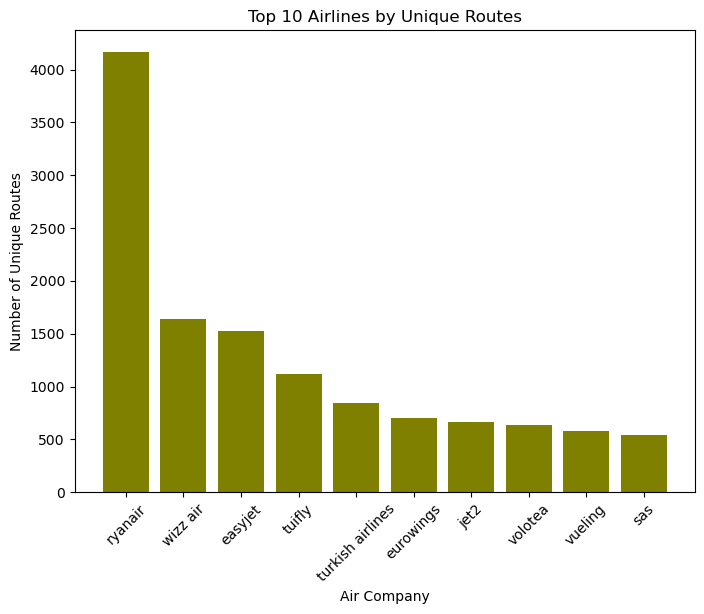

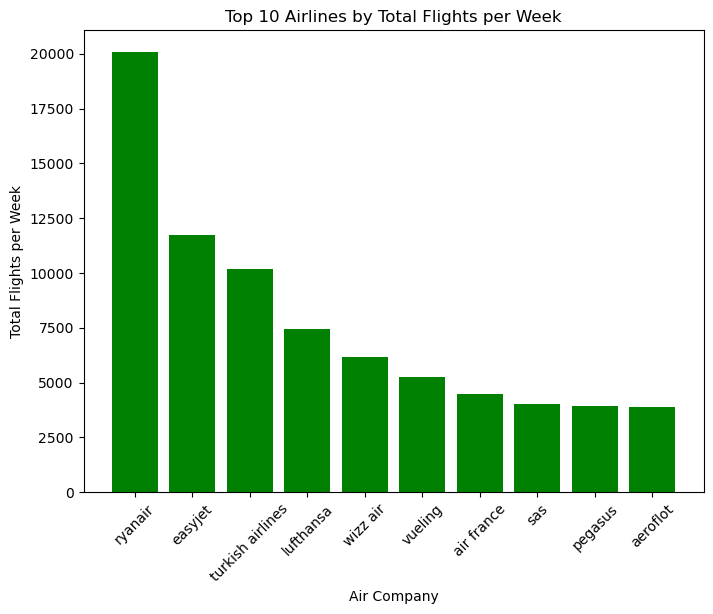

In [314]:
# Group the data by airline and count the number of unique routes for each airline
route_counts = new_df.groupby('airline_name').apply(lambda x: len(x[['departure_iataCode', 'arrival_iataCode']]))
route_counts = route_counts.sort_values(ascending=False)[:10]

# Create a bar chart showing the number of unique routes for each airline
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(route_counts.index, route_counts.values, color=['olive'])
ax.set_title('Top 10 Airlines by Unique Routes')
ax.set_xlabel('Air Company')
ax.set_ylabel('Number of Unique Routes')
plt.xticks(rotation=45)

# Group the data by airline and sum the number of flights for each airline
flight_counts = new_df.groupby('airline_name')['counts'].sum()
flight_counts = flight_counts.sort_values(ascending=False)[:10]

# Create a bar chart showing the total number of flights for each airline
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(flight_counts.index, flight_counts.values, color=['green'])
ax.set_title('Top 10 Airlines by Total Flights per Week')
ax.set_xlabel('Air Company')
ax.set_ylabel('Total Flights per Week')
plt.xticks(rotation=45)

plt.show()

In [315]:
from math import radians, sin, cos, sqrt, atan2
def distance(row):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row['Latitude_origin'])
    lon1 = radians(row['Longitude_origin'])
    lat2 = radians(row['Latitude_dest'])
    lon2 = radians(row['Longitude_dest'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance
new_df['distance'] = new_df.apply(distance, axis=1)

In [243]:
dflights_j.sort_values(by="counts",ascending= False).head(40)

,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name_dest,City_dest,Country_dest,Latitude_dest,Longitude_dest,Altitude
4825,2985,SVO,LED,Sheremetyevo International Airport,Moscow,Russia,55.972599,37.414600,aeroflot,239,2948,Pulkovo Airport,St. Petersburg,Russia,59.800301,30.262501,78
4908,2948,LED,SVO,Pulkovo Airport,St. Petersburg,Russia,59.800301,30.262501,aeroflot,238,2985,Sheremetyevo International Airport,Moscow,Russia,55.972599,37.414600,622
4873,2965,AER,SVO,Sochi International Airport,Sochi,Russia,43.449902,39.956600,aeroflot,177,2985,Sheremetyevo International Airport,Moscow,Russia,55.972599,37.414600,622
24685,2985,SVO,AER,Sheremetyevo International Airport,Moscow,Russia,55.972599,37.414600,aeroflot,172,2965,Sochi International Airport,Sochi,Russia,43.449902,39.956600,89
11994,1688,AYT,IST,Antalya International Airport,Antalya,Turkey,36.898701,30.800501,turkish airlines,133,13696,Istanbul Airport,Istanbul,Turkey,41.275278,28.751944,325
1162,13696,IST,AYT,Istanbul Airport,Istanbul,Turkey,41.275278,28.751944,turkish airlines,131,1688,Antalya International Airport,Antalya,Turkey,36.898701,30.800501,177
17496,1688,AYT,VKO,Antalya International Airport,Antalya,Turkey,36.898701,30.800501,turkish airlines,111,2988,Vnukovo International Airport,Moscow,Russia,55.591499,37.261501,685
17523,2948,LED,VKO,Pulkovo Airport,St. Petersburg,Russia,59.800301,30.262501,rossiya airlines,111,2988,Vnukovo International Airport,Moscow,Russia,55.591499,37.261501,685
24648,4029,DME,AER,Domodedovo International Airport,Moscow,Russia,55.408798,37.906300,ural airlines,109,2965,Sochi International Airport,Sochi,Russia,43.449902,39.956600,89
14050,2965,AER,DME,Sochi International Airport,Sochi,Russia,43.449902,39.956600,ural airlines,109,4029,Domodedovo International Airport,Moscow,Russia,55.408798,37.906300,588


In [316]:
# Initialize the graph
L = nx.Graph()

# Add the nodes with their attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    origin_lat = row['Latitude_origin']
    origin_long = row['Longitude_origin']
    destination_lat = row['Latitude_dest']
    destination_long = row['Longitude_dest']
    origin_city = row['City_origin']
    destination_city = row['City_dest']
    origin_code = row['departure_iataCode']
    dest_code =row['arrival_iataCode']
    origin_airportname = row['Name_origin']
    dest_airportname = row['Name_dest']
   
    
    L.add_node(origin, lat=origin_lat, lng=origin_long, city=origin_city, code=origin_code, airport = origin_airportname)
    L.add_node(destination, lat=destination_lat, lng=destination_long, city=destination_city, code=dest_code, airport = dest_airportname)

# Add the edges with the attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    cnts = row['counts']
    airline_name = row['airline_name']
    kilometers = row['distance']
    
    L.add_edge(origin, destination, weight= kilometers, airline_name =airline_name )

# Save the graph to disk
#nx.write_gml(G, "flights_graph.gml")


nx.write_gexf(L, "graph2022_august.gexf")

In [308]:
# Initialize the graph
F = nx.MultiDiGraph()

# Add the nodes with their attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    origin_lat = row['Latitude_origin']
    origin_long = row['Longitude_origin']
    destination_lat = row['Latitude_dest']
    destination_long = row['Longitude_dest']
    origin_city = row['City_origin']
    destination_city = row['City_dest']
    origin_code = row['departure_iataCode']
    dest_code =row['arrival_iataCode']
    origin_airportname = row['Name_origin']
    dest_airportname = row['Name_dest']
   
    F.add_node(origin, lat=origin_lat, lng=origin_long, city=origin_city, code=origin_code, airport=origin_airportname)
    F.add_node(destination, lat=destination_lat, lng=destination_long, city=destination_city, code=dest_code, airport=dest_airportname)

# Add the edges with the attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    cnts = row['counts']
    airline_name = row['airline_name']
    kilometers = row['distance']
    
    # Add a new edge with the count and airline name as attributes
    F.add_edge(origin, destination, weight=kilometers, airline_name=airline_name, number_flights = cnts)

# Write the graph to a file
nx.write_gexf(F, "fixed_graph2022_august.gexf")


#### GRAPH ANALYSIS

In [317]:
print('Number of nodes: {} - Number of links: {}'.format(L.order(),L.size()))

Number of nodes: 1054 - Number of links: 11736


the density of a graph is a measure of how many edges are present in the graph relative to the total number of possible edges. It is calculated as the ratio of the actual number of edges to the total number of possible edges in the graph.

In [310]:
L_density = nx.density(L)
print("Density: " + str(L_density))

Density: 0.021148575228271623


In [311]:
L_degree = list(dict(L.degree()).values())

In [312]:
print("European Air Transportation Graph Degree statistics: ")
print("Mean: " + str(round(np.mean(L_degree),4)))
print("Median: " + str(np.median(L_degree))) 
print("Standard deviation: " + str(round(np.std(L_degree),4)))
print("Maximum: " + str(np.max(L_degree)))
print("Minimum: " + str(np.min(L_degree)))

European Air Transportation Graph Degree statistics: 
Mean: 22.2694
Median: 5.0
Standard deviation: 39.8251
Maximum: 294
Minimum: 1


#### Minimum degree is 1, so there as no isolated nodes. Mean value is higher that median, so we deal with a scale-free network. To verify this we will check degree distribution and compare it to the random network degree distribution

A scale-free network is a type of network where the distribution of node degrees (the number of connections per node) follows a power law.
This means that a few nodes have a very high degree of connections, while most nodes have only a few connections.



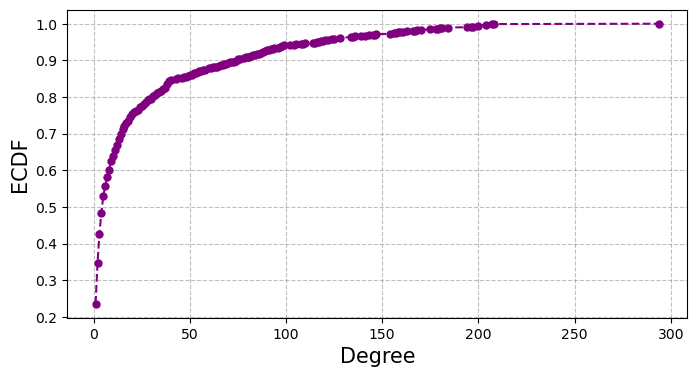

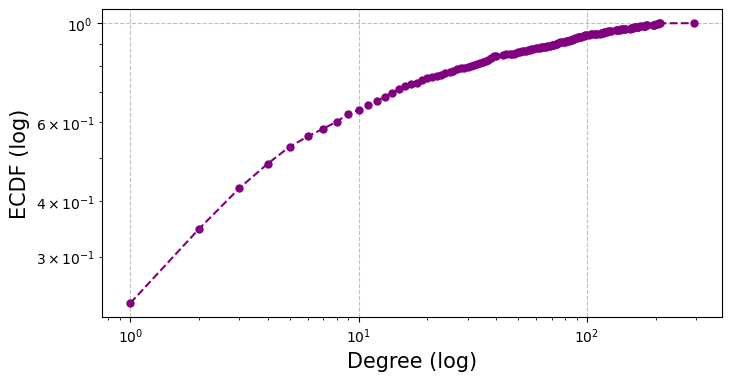

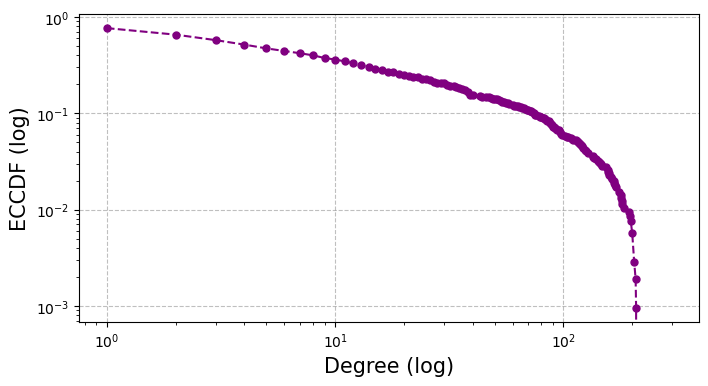

In [249]:
# ECDF in linear scale
cdf_function = ECDF(L_degree)
x = np.unique(L_degree)
y = cdf_function(x)

fig_cdf_function = plt.figure(figsize=(8, 4)) 
axes = fig_cdf_function.gca()

axes.plot(x, y, color='purple', linestyle='--', marker='o', ms=5)
axes.set_xlabel('Degree', size=15)
axes.set_ylabel('ECDF', size=15)
axes.grid(True, which='major', linestyle='--', color='grey', alpha=.5)

# ECDF in loglog scale
fig_cdf_function = plt.figure(figsize=(8, 4))
axes = fig_cdf_function.gca()

axes.loglog(x, y, color='purple', linestyle='--', marker='o', ms=5)
axes.set_xlabel('Degree (log)', size=15)
axes.set_ylabel('ECDF (log)', size=15)
axes.grid(True, which='major', linestyle='--', color='grey', alpha=.5)

# ECCDF in loglog scale
y = 1 - cdf_function(x)

fig_ccdf_function = plt.figure(figsize=(8, 4))
axes = fig_ccdf_function.gca()

axes.loglog(x, y, color='purple', linestyle='--', marker='o', ms=5)
axes.set_xlabel('Degree (log)', size=15)
axes.set_ylabel('ECCDF (log)', size=15)
axes.grid(True, which='major', linestyle='--', color='grey', alpha=.5)

## Erdös-Renyi MODEL

In [250]:
p=L_density

In [251]:
rn = nx.fast_gnp_random_graph(L.order(),p)

In [252]:
print('Number of nodes: {} - Number of links: {}'.format(rn.order(),rn.size()))

Number of nodes: 1054 - Number of links: 11740


In [253]:
rn_degree = list(dict(rn.degree()).values())

In [254]:
print("Random Graph Degree statistics (Based on  model): ")
print("Mean: " + str(round(np.mean(rn_degree),4)))
print("Median: " + str(np.median(rn_degree))) 
print("Standard deviation: " + str(round(np.std(rn_degree),4)))
print("Maximum: " + str(np.max(rn_degree)))
print("Minimum: " + str(np.min(rn_degree)))

Random Graph Degree statistics (Based on  model): 
Mean: 22.277
Median: 22.0
Standard deviation: 4.8102
Maximum: 40
Minimum: 7


Text(0, 0.5, 'ECCDF (log)')

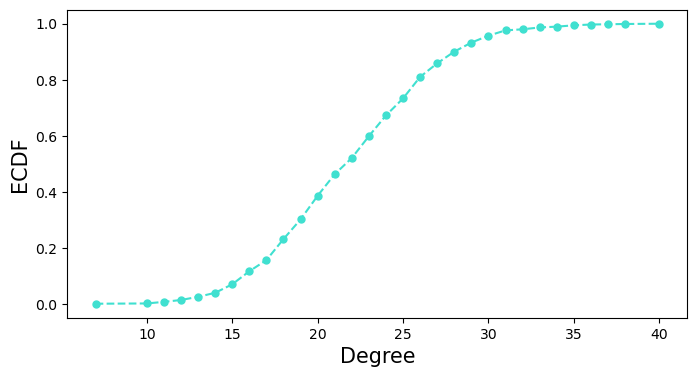

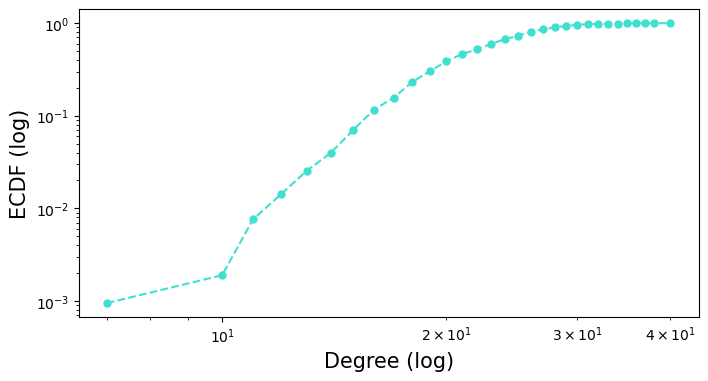

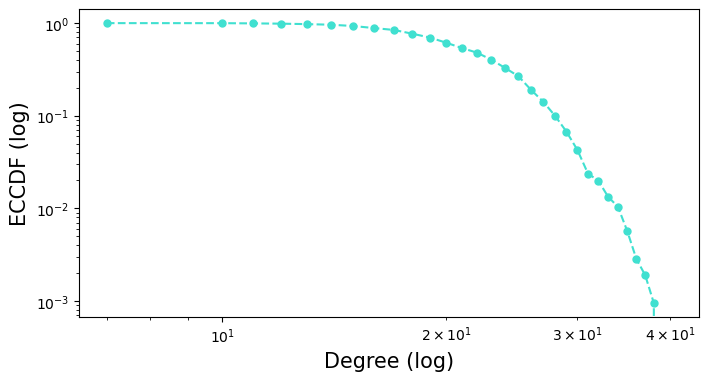

In [255]:
# ECDF in linear scale
cdf_function = ECDF(rn_degree)
x = np.unique(rn_degree)
y = cdf_function(x)
fig_cdf_function = plt.figure(figsize=(8,4)) 
axes = fig_cdf_function.gca()
axes.plot(x,y,color = 'turquoise', linestyle = '--', marker= 'o',ms = 5)
axes.set_xlabel('Degree',size = 15)
axes.set_ylabel('ECDF',size = 15)

#ECDF in loglog scale
fig_cdf_function = plt.figure(figsize=(8,4))
axes = fig_cdf_function.gca()
axes.loglog(x,y,color = 'turquoise', linestyle = '--', marker= 'o',ms = 5)
axes.set_xlabel('Degree (log)',size = 15)
axes.set_ylabel('ECDF (log)',size = 15)

# ECCDF in loglog scale
y = 1-cdf_function(x)
fig_ccdf_function = plt.figure(figsize=(8,4))
axes = fig_ccdf_function.gca()
axes.loglog(x,y,color = 'turquoise', linestyle = '--', marker= 'o',ms = 5)
axes.set_xlabel('Degree (log)',size = 15)
axes.set_ylabel('ECCDF (log)',size = 15)

In [257]:
percentile_99 = np.percentile(L_degree,99)
print(percentile_99)

188.70000000000027


In [258]:
#HUBS 

hub = [k for k,v in dict(L.degree()).items() if v>= percentile_99]
print('Number of hubs:',len(hub))
print('List of hubs:', list(hub))

print('Number of isolated nodes:', list(nx.isolates(L)))

Number of hubs: 11
List of hubs: [1218, 302, 599, 13696, 1229, 346, 3998, 548, 1613, 1678, 1688]
Number of isolated nodes: []


In [259]:
df_hubs = dflights_j[dflights_j['Airport ID_x'].isin(hub)]['City_origin'].unique()
print(df_hubs)
                            

['Barcelona' 'Brussels' 'Dublin' 'Istanbul' 'Madrid' 'Munich'
 'Palma de Mallorca' 'London' 'Vienna' 'Zurich' 'Antalya']


In [260]:
print(nx.is_connected(L))
print(nx.number_connected_components(L))

True
1


In [261]:
components = nx.connected_components(L)
for i, component in enumerate(components):
    print(f"Airports in connected component {i+1}:")
    for airport in component:
        print(airport)
    print()

Airports in connected component 1:
8192
6146
6147
2050
6149
6150
7
8
2057
9
11
10
6152
12
4111
16
13
18
14
15
2064
6162
6158
6165
6166
2072
6164
2074
4119
4130
2082
4144
4160
4161
4162
4166
70
73
8266
2121
2131
2053
4089
4190
4191
4192
4193
4194
4195
4196
4197
4198
2157
111
113
2162
4216
2170
2171
2172
4222
2176
2177
2179
2180
2188
2190
2191
4099
146
2194
4100
156
4252
2206
2207
2067
4274
178
2234
2235
2236
4108
189
193
2241
4292
4297
6345
209
210
4309
6148
4313
4315
220
4317
8414
221
4316
4322
2276
4325
4326
2279
231
4328
4330
4327
234
230
238
4331
8428
6153
4336
6154
245
246
6390
248
4345
4347
4348
253
6156
4350
4352
4353
6157
260
4357
4359
4362
4364
4365
6159
4367
4368
273
2322
4371
4369
4373
4374
4375
6161
280
6160
4379
286
287
6163
8482
293
295
299
302
304
308
309
310
2359
6464
6466
6467
8208
338
339
340
341
342
6485
344
345
346
347
348
349
350
6493
352
353
2397
355
356
6492
6505
364
370
371
373
374
378
382
393
399
400
410
412
413
414
415
416
421
8613
428
429
430
432
433
435
437
4

In [262]:
L_triangles_list = list(nx.triangles(L).values())

In [263]:
# get the number of triangles for each node
triangles = nx.triangles(L)

# print the number of triangles for each node
for node, num_triangles in triangles.items():
    print(f"Node {node} is part of {num_triangles} triangles.")
    
    

Node 628 is part of 177 triangles.
Node 1230 is part of 3645 triangles.
Node 607 is part of 119 triangles.
Node 532 is part of 393 triangles.
Node 1212 is part of 2584 triangles.
Node 299 is part of 29 triangles.
Node 737 is part of 3724 triangles.
Node 3941 is part of 4146 triangles.
Node 1218 is part of 5173 triangles.
Node 465 is part of 649 triangles.
Node 636 is part of 828 triangles.
Node 1525 is part of 2993 triangles.
Node 469 is part of 2224 triangles.
Node 1216 is part of 789 triangles.
Node 608 is part of 2054 triangles.
Node 1538 is part of 3077 triangles.
Node 1264 is part of 2088 triangles.
Node 494 is part of 141 triangles.
Node 490 is part of 2252 triangles.
Node 302 is part of 4039 triangles.
Node 1423 is part of 2495 triangles.
Node 1489 is part of 4205 triangles.
Node 1367 is part of 1032 triangles.
Node 344 is part of 4135 triangles.
Node 1553 is part of 938 triangles.
Node 1652 is part of 881 triangles.
Node 609 is part of 4251 triangles.
Node 304 is part of 1902 t

In [264]:
transitivity = nx.transitivity(L)
print(transitivity)

0.3150436819815396


transitivity is a measure of the extent to which triangles or triplets in a network are closed. It is defined as the ratio of the number of triangles in a network to the number of connected triples (i.e., the number of triplets that have at least two connected edges). A higher transitivity indicates a higher tendency for nodes to be connected in clusters, which can reflect the presence of cohesive groups or communities within the network.

In [265]:
print('g - average local clustering: {}'.format(nx.average_clustering(L)))

g - average local clustering: 0.4475740694386584


Average local clustering, also known as average clustering coefficient, is a measure of the level of connectivity or clustering among the immediate neighbors of a node in a network. Specifically, it is the average of the local clustering coefficients of all the nodes in the network, where the local clustering coefficient of a node is the ratio of the number of triangles in which the node is a participant to the number of triplets in which the node participates. The average local clustering coefficient is often used as a summary statistic to characterize the overall level of clustering in a network. It is a value between 0 and 1, where a higher value indicates a higher degree of clustering or connectivity among neighboring nodes.

In [266]:
print("Local Clustering Coefficient statistics (L): ")
print('European Network - mean local clustering: {}'.format(np.mean(list(nx.clustering(L).values()))))
print('European Network  - standard deviation local clustering: {}'.format(np.std(list(nx.clustering(L).values()))))
print('European Network  - median local clustering: {}'.format(np.median(list(nx.clustering(L).values()))))
print('European Network  - max local clustering: {}'.format(np.max(list(nx.clustering(L).values()))))
print('European Network  - min local clustering: {}'.format(np.min(list(nx.clustering(L).values()))))

Local Clustering Coefficient statistics (L): 
European Network - mean local clustering: 0.4475740694386587
European Network  - standard deviation local clustering: 0.34903679059234055
European Network  - median local clustering: 0.46190476190476193
European Network  - max local clustering: 1.0
European Network  - min local clustering: 0.0


In [267]:
local_clustering_L = list(nx.clustering(L).values())

Text(0, 0.5, 'ECCDF (log)')

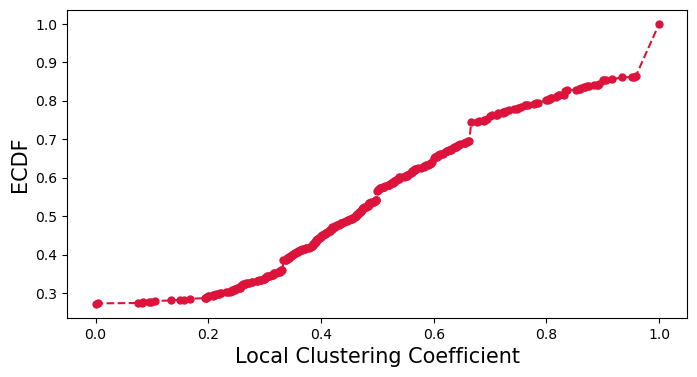

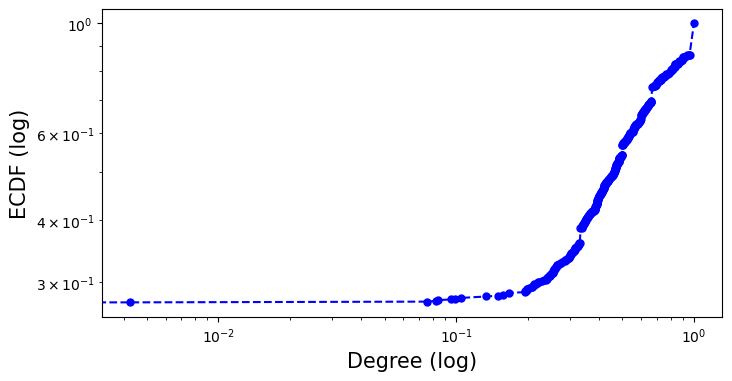

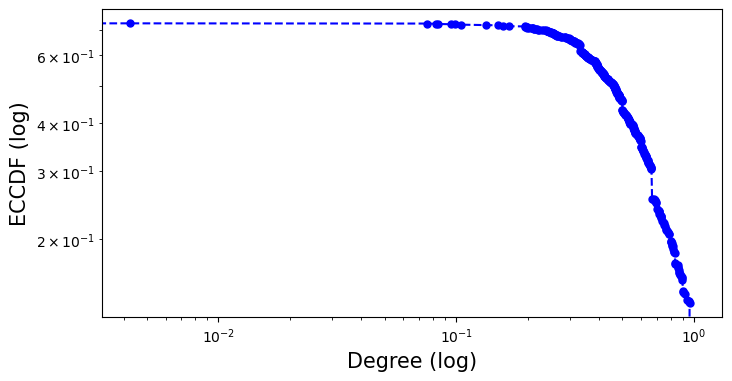

In [268]:
# ECDF in linear scale
cdf_function = ECDF(local_clustering_L)
x = np.unique(local_clustering_L)
y = cdf_function(x)
fig_cdf_function = plt.figure(figsize=(8,4)) 
axes = fig_cdf_function.gca()
axes.plot(x,y,color = 'crimson', linestyle = '--', marker= 'o',ms = 5)
axes.set_xlabel('Local Clustering Coefficient',size = 15)
axes.set_ylabel('ECDF',size = 15)

#ECDF in loglog scale
fig_cdf_function = plt.figure(figsize=(8,4))
axes = fig_cdf_function.gca()
axes.loglog(x,y,color = 'blue', linestyle = '--', marker= 'o',ms = 5)
axes.set_xlabel('Degree (log)',size = 15)
axes.set_ylabel('ECDF (log)',size = 15)

# ECCDF in loglog scale
y = 1-cdf_function(x)
fig_ccdf_function = plt.figure(figsize=(8,4))
axes = fig_ccdf_function.gca()
axes.loglog(x,y,color = 'blue', linestyle = '--', marker= 'o',ms = 5)
axes.set_xlabel('Degree (log)',size = 15)
axes.set_ylabel('ECCDF (log)',size = 15)

In [269]:
print("Pearson coefficient and p-value between Degree and Clustering coefficient: ")
print(scipy.stats.pearsonr(L_degree, local_clustering_L))

Pearson coefficient and p-value between Degree and Clustering coefficient: 
PearsonRResult(statistic=-0.08204986485306529, pvalue=0.007696251411984032)


In [270]:
degree_centrality = nx.degree_centrality(L)
eigenvector_centrality = nx.eigenvector_centrality(L)
pr_centrality = nx.pagerank(L)

hub_degree = sorted(degree_centrality.items(),key = lambda x:x[1], reverse=True)[0]
hub_eigenvector = sorted(eigenvector_centrality.items(),key = lambda x:x[1], reverse=True)[0]
hub_pagerank = sorted(pr_centrality.items(),key = lambda x:x[1], reverse=True)[0]

print('degree:      ',hub_degree)
print('eigenvector: ',hub_eigenvector)
print('pagerank: ',hub_eigenvector)

degree:       (13696, 0.2792022792022792)
eigenvector:  (1613, 0.12673008071577302)
pagerank:  (1613, 0.12673008071577302)


In [271]:
print("Pearson coefficient and p-value between Degree and Eigenvector Centralities: ")
print(scipy.stats.pearsonr(list(degree_centrality.values()),list(eigenvector_centrality.values())))
print("Pearson coefficient and p-value between Degree and PageRank Centralities: ")
print(scipy.stats.pearsonr(list(degree_centrality.values()),list(pr_centrality.values())))
print("Pearson coefficient and p-value between Eigenvector and PageRank Centralities: ")
print(scipy.stats.pearsonr(list(eigenvector_centrality.values()),list(pr_centrality.values())))



Pearson coefficient and p-value between Degree and Eigenvector Centralities: 
PearsonRResult(statistic=0.9661787952058554, pvalue=0.0)
Pearson coefficient and p-value between Degree and PageRank Centralities: 
PearsonRResult(statistic=0.8312303674285455, pvalue=1.7003416777662738e-270)
Pearson coefficient and p-value between Eigenvector and PageRank Centralities: 
PearsonRResult(statistic=0.7035705163610186, pvalue=2.94562642457388e-158)


In [272]:

print("Spearman and Kendall coefficient between Degree and Eigenvector Centralities: ")
print(scipy.stats.spearmanr(list(degree_centrality.values()),list(eigenvector_centrality.values())))

print("Spearman and Kendall coefficient between Degree and PageRank Centralities: ")
print(scipy.stats.kendalltau(list(degree_centrality.values()),list(pr_centrality.values())))

print("Spearman and Kendall coefficient between Eigenvector and PageRank Centralities: ")
print(scipy.stats.kendalltau(list(eigenvector_centrality.values()),list(pr_centrality.values())))

Spearman and Kendall coefficient between Degree and Eigenvector Centralities: 
SpearmanrResult(correlation=0.8943659805986316, pvalue=0.0)
Spearman and Kendall coefficient between Degree and PageRank Centralities: 
KendalltauResult(correlation=0.7031372714902483, pvalue=2.048133308177653e-238)
Spearman and Kendall coefficient between Eigenvector and PageRank Centralities: 
KendalltauResult(correlation=0.5026989175717482, pvalue=1.4599455416412674e-131)


In [273]:
#ASSORTATIVITY - STUDY WHEN CONNECT ADDITIONAL ATTRIBUTES

In [274]:
print("Degree assortativity: " + str(nx.degree_assortativity_coefficient(L)))

Degree assortativity: -0.2122664597666499


In [275]:
#COMMUNITY DETECTION

In [276]:
partition_library = community_louvain.best_partition(L)

In [277]:
print(set(partition_library.values()))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}


In [278]:
nx.set_node_attributes(L, partition_library, "community_library")

In [279]:
comms = set(partition_library.values())

In [280]:
list_community_sets_library = [ set() for i in range(len(comms)) ]

In [281]:
for n, comm in partition_library.items():
    list_community_sets_library[comm].add(n)

In [282]:
#print("Coverage")
print("Coverage", nx_comm.coverage(L, list_community_sets_library))
#print("Modularity")
print("Modularity", nx_comm.modularity(L, list_community_sets_library, weight='weight'))
#print("Performance")
#print("Performance", nx_comm.performance(G, my_list))

Coverage 0.4097648261758691
Modularity 0.35948675206240405


Coverage is a measure of how well a given set of communities covers the nodes in a network. It is defined as the fraction of nodes that are assigned to at least one community. A higher coverage means that the communities are able to capture a larger fraction of the nodes in the network.

Modularity, on the other hand, measures the quality of a given partition of a network into communities. It is defined as the difference between the fraction of edges within communities and the expected fraction of edges within communities if the edges were distributed at random. A higher modularity means that the communities are more tightly connected with each other than expected by chance, indicating a stronger community structure in the network.

In [283]:
pairs = []
for i, nodes in enumerate(list_community_sets_library):
    print(i,len(nodes))
    comm_size = (i,len(nodes))
    pairs.append(comm_size)

0 2
1 207
2 111
3 28
4 112
5 172
6 2
7 5
8 164
9 14
10 66
11 171


In [284]:
community_index = []
number_of_nodes = []

for comm, n_nodes in pairs:
    community_index.append(str(comm))
    number_of_nodes.append(n_nodes) 

Text(0, 0.5, 'Number of nodes')

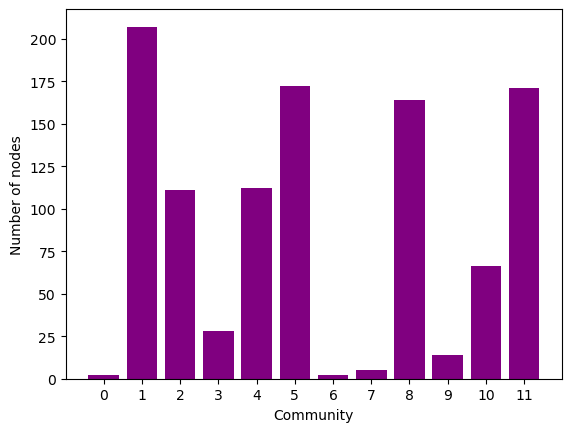

In [285]:
plt.bar(community_index,number_of_nodes, color='purple')
plt.xlabel("Community")
plt.ylabel("Number of nodes")



Centrality in communities


In [286]:
for comm in list_community_sets_library:
    subgraph = L.subgraph(comm)

In [287]:
centr_comm = {}
# node -> centrality in the community subgraph

In [288]:
for comm in list_community_sets_library:
    subgraph = L.subgraph(comm)
    subgraph.order()
    nx.degree_centrality(subgraph)
    
    node_degrees  = nx.degree_centrality(subgraph)
    for n,d in node_degrees.items():
        centr_comm[n] = d

In [289]:
nx.set_node_attributes(L, centr_comm, "centr_comm")

In [290]:
nx.has_bridges(L)

True

In [291]:
nx.write_gexf(L, "Laugust.gexf")

In [292]:
bridges = list(nx.bridges(L))
print("List of bridges:", bridges)

List of bridges: [(737, 722), (737, 714), (737, 698), (3941, 5787), (3941, 4193), (3941, 4194), (3941, 4190), (3941, 1453), (3941, 1463), (1218, 5781), (1525, 441), (494, 3385), (302, 1120), (302, 3393), (302, 1059), (609, 9), (609, 10), (599, 5577), (535, 3845), (1555, 1145), (1555, 3351), (534, 5575), (534, 5563), (687, 742), (1665, 4017), (421, 429), (421, 430), (421, 433), (421, 437), (421, 448), (421, 416), (13696, 5801), (13696, 9273), (13696, 6783), (13696, 3967), (13696, 1154), (13696, 3275), (13696, 797), (13696, 1177), (13696, 3940), (13696, 3199), (13696, 2121), (13696, 4119), (13696, 1173), (13696, 3125), (13696, 2207), (13696, 5687), (13696, 4331), (13696, 1094), (13696, 4161), (13696, 886), (13696, 3205), (13696, 2157), (13696, 1157), (16, 8), (16, 3995), (16, 3858), (16, 3720), (502, 2874), (502, 2895), (502, 1779), (502, 2894), (502, 111), (1399, 1431), (1638, 2526), (1638, 2531), (1638, 4162), (1638, 2537), (1638, 2559), (1638, 1628), (1638, 2597), (1638, 5665), (1638,

In [293]:
df_bridges = dflights_j[dflights_j[['Airport ID_x', 'Airport ID_y']].apply(tuple, axis=1).isin(bridges)]
df_bridges.tail(20)
                            

,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name_dest,City_dest,Country_dest,Latitude_dest,Longitude_dest,Altitude
30725,1612,SZG,LTT,Salzburg Airport,Salzburg,Austria,47.793301,13.004300,airlink,2,5786,La Môle Airport,La Môle,France,43.205399,6.482000,59
30726,1612,SZG,SLC,Salzburg Airport,Salzburg,Austria,47.793301,13.004300,vistajet,1,3536,Salt Lake City International Airport,Salt Lake City,United States,40.788399,-111.977997,4227
30727,3973,TBS,AJF,Tbilisi International Airport,Tbilisi,Georgia,41.669201,44.954700,georgian airways,2,5925,Al-Jawf Domestic Airport,Al-Jawf,Saudi Arabia,29.785101,40.099998,2261
30730,415,TLL,KDL,Lennart Meri Tallinn Airport,Tallinn-ulemiste International,Estonia,59.413300,24.832800,ais airlines,13,412,Kärdla Airport,Kardla,Estonia,58.990799,22.830700,18
30731,415,TLL,URE,Lennart Meri Tallinn Airport,Tallinn-ulemiste International,Estonia,59.413300,24.832800,flexflight,1,413,Kuressaare Airport,Kuressaare,Estonia,58.229900,22.509501,14
30732,415,TLL,URE,Lennart Meri Tallinn Airport,Tallinn-ulemiste International,Estonia,59.413300,24.832800,nyxair,12,413,Kuressaare Airport,Kuressaare,Estonia,58.229900,22.509501,14
30733,1273,TLS,AGB,Toulouse-Blagnac Airport,Toulouse,France,43.629101,1.363820,british airways,1,374,Augsburg Airport,Augsburg,Germany,48.425278,10.931667,1516
30734,1726,TZX,OHS,Trabzon International Airport,Trabzon,Turkey,40.995098,39.789700,salamair,1,11328,Sohar Airport,Sohar,Oman,24.386040,56.625410,20
30735,1417,UIP,VIY,Quimper-Cornouaille Airport,Quimper,France,47.974998,-4.167790,astonjet,1,1388,Villacoublay-Vélizy (BA 107) Air Base,Villacoublay,France,48.774167,2.191667,584
30738,2988,VKO,BXY,Vnukovo International Airport,Moscow,Russia,55.591499,37.261501,rusline,1,8192,Krainiy Airport,Baikonur,Kazakhstan,45.621994,63.210773,317


In [294]:
# Initialize the graph
L = nx.Graph()

# Add the nodes with their attributes
for i, row in dflights_j.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    origin_lat = row['Latitude_origin']
    origin_long = row['Longitude_origin']
    destination_lat = row['Latitude_dest']
    destination_long = row['Longitude_dest']
    origin_city = row['City_origin']
    destination_city = row['City_dest']
    origin_code = row['departure_iataCode']
    dest_code =row['arrival_iataCode']
    origin_airportname = row['Name_origin']
    dest_airportname = row['Name_dest']
   
    
    L.add_node(origin, lat=origin_lat, lng=origin_long, city=origin_city, code=origin_code, airport = origin_airportname)
    L.add_node(destination, lat=destination_lat, lng=destination_long, city=destination_city, code=dest_code, airport = dest_airportname)

# Add the edges with the attributes
for i, row in dflights_j.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    cnts = row['counts']
    airline_name = row['airline_name']
    
    L.add_edge(origin, destination, weight= cnts, airline_name =airline_name )
    
# set bridge attribute to True for corresponding edges
for u, v in bridges:
    L[u][v]['bridge'] = True

# Save the graph to disk
#nx.write_gml(G, "flights_graph.gml")


nx.write_gexf(L, "bridges_graph2022_augusteurope.gexf")

In [295]:
L.number_of_nodes()

1054

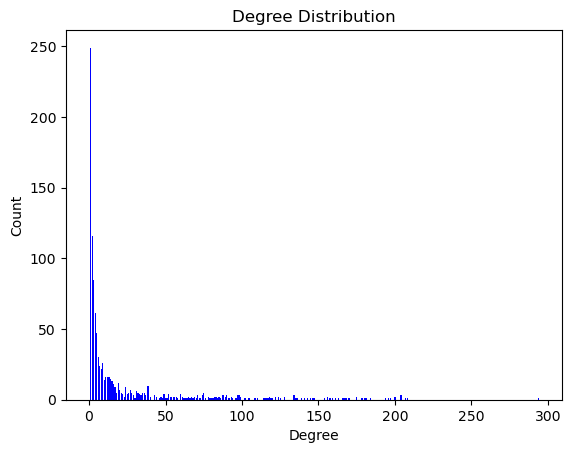

In [296]:
degree_sequence = sorted([d for n, d in L.degree()], reverse=True)
degree_count = nx.degree_histogram(L)
plt.bar(range(len(degree_count)), degree_count, width=0.8, color='b')
plt.title('Degree Distribution')
plt.ylabel('Count')
plt.xlabel('Degree')
plt.show()